# Example: Basic features of Qiskit

This Jupyter notebook demonstrates the very basic features of Qiskit for creating quantum circuits, simulating them on various backends and visualizing the results. You can use it as a reference throughout the tutorial.

## Import the necessary packages

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.visualization import *
from qiskit.quantum_info import state_fidelity
# Import numpy 
import numpy as np
# Magic function to render plots in the notebook after the cell executing the plot command
%matplotlib inline

## Running a simulaton of a basic experiment

### 1. Create and visualize the quantum circuit(s)

The following command creates an empty quantum circuit with `num_qubits` qubits, where all qubits are initialized in the $|0\rangle$ state.

In [2]:
num_qubits = 3
qc = QuantumCircuit(num_qubits)

The corresponding circuit diagram can be drawn using the `draw` method. The (optional) argument tells Qiskit to use Matplotlib for the output which results in a little nicer output.

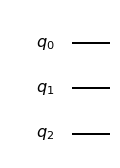

In [3]:
qc.draw(output='mpl')

Right now our quantum circuit is still empty, we need to add gates acting on the qubits.

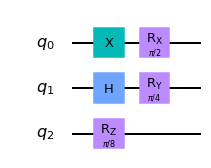

In [4]:
# Add an X-gate acting on qubit 0
qc.x(0)
# Add a Hadamard gate acting on qubit 1
qc.h(1)
# Add rotations R_p(theta), p={X, Y, Z} acting on the qubits
qc.rx(np.pi/2, 0)
qc.ry(np.pi/4, 1)
qc.rz(np.pi/8, 2)
# Look at the result using the draw method
qc.draw(output='mpl')

So far we have only added single-qubit gates. Two-qubit gates can be added in the same way.

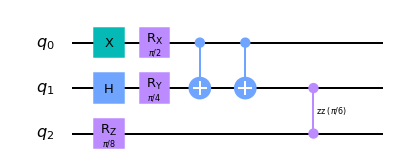

In [5]:
# Add a CNOT gate. The first argument is the index of thecontrol qubit, 
# the second one the index of the target qubit
qc.cnot(0,1)
# Alternatively a CNOT can be added with the method cx
qc.cx(0,1)
# Add the R_zz(theta) gate between qubits 1 and 2
qc.rzz(np.pi/6, 1, 2)
# Visualize the result
qc.draw(output='mpl')

If we want run the experiment on quantum hardware or a classical simulator emulating quantum hardware, we have to add a final measurement to the qubits to obtain information about the quantum state.

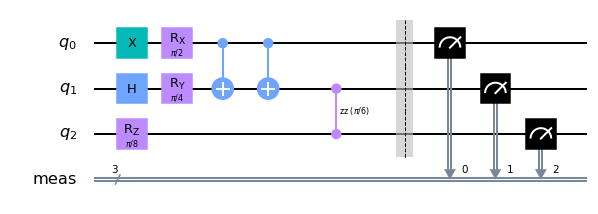

In [6]:
# Add a measurement to all qubits
qc.measure_all()
# Visualize the result once more
qc.draw(output='mpl')

The double line indicates a classical register where the number on top of the slash indicates how many classical registers we have. The k-th classical register will hold the measurement outcome of qubit k.

### 2. Simulate the experiment

In the following we simulate the quantum circuit on a classical simulator emulating the behavior of an (ideal) quantum computer. As such we have to run the circuit multiple times and record the statistics of the outcomes. The number of these repetitions is referred to as `shots` in Qiskit.

In [7]:
# Generate a qasm_simulator backend which emulates a quantum computer
qasm_simulator = Aer.get_backend('qasm_simulator')
# Execute the circuit on the qasm_simulator backend with 500 shots
job = execute(qc, qasm_simulator, shots=500)
# Retrieve the results from the job object
result = job.result()
# Among other information the result object contains the information
# about the measurement outcomes
counts = result.get_counts()
print('Total counts for the computational basis states:',counts)

Total counts for the computational basis states: {'000': 37, '001': 30, '010': 223, '011': 210}


### 3. Visualize the results and evaluate the data

After obtaining the statistics for the measurement outcomes, we can visualize our data and compute oversvables.

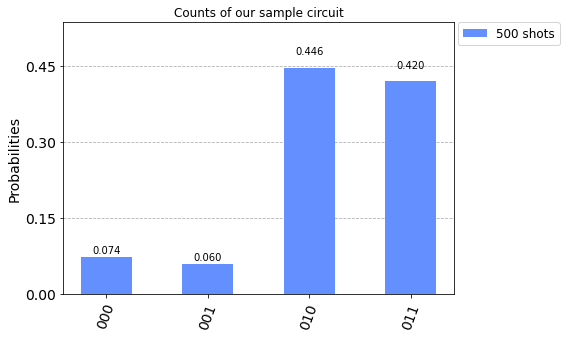

In [8]:
# Plot a simple histogram
plot_histogram(counts, title='Counts of our sample circuit', legend=['500 shots'])

Multiple outcomes can be plotted in a single histogram, to this end let us rerun our example with a different number of shots and compare both results.

In [9]:
# Run the circuit on the qasm_simulator backend, but now with 8000 shots
job2 = execute(qc, qasm_simulator, shots=8000)
# Retrieve the counts
result2 = job2.result()
counts2 = result2.get_counts()

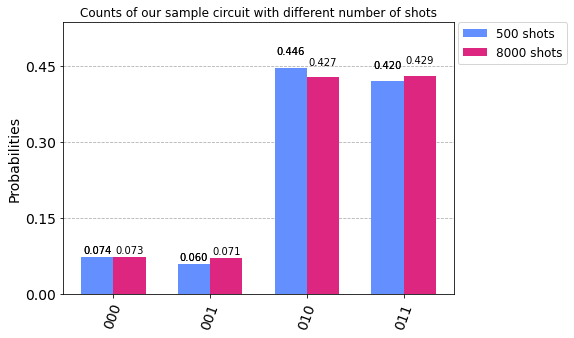

In [10]:
# Plot a histogram containing both results
plot_histogram([counts, counts2], title='Counts of our sample circuit with different number of shots', legend=['500 shots', '8000 shots'])

From the measurement outcomes we can compute observables which are diagonal in the computational basis. Assuming $D=\mathrm{diag}(\lambda_0,\dots,\lambda_{2^N-1})$ we can calculate $\langle \psi |D|\psi\rangle$ by expanding the wave function in the computational basis, $|\psi\rangle = \sum_i c_i |i\rangle$:
$$\langle \psi |D|\psi\rangle = \sum_{i=0}^{2^N-1} |c_i|^2 \lambda_i.$$
Dividing the counts by the number of shots, we get an estimate for $|c_i|^2$.

## The state vector simulator

The `qasm_simulator` only yields the counts for the different basis states. For developing and debugging it is often useful to look at the state vector. While this cannot be done efficiently on a quantum computer, Qiskit offers the possibility to obtain the state vector using the `statevector_simulator` backend.

### Generating a simple circuit and running it on the state vector simulator

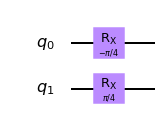

In [11]:
qc2 = QuantumCircuit(2)
qc2.rx(-np.pi/4,0)
qc2.rx(+np.pi/4,1)
qc2.draw(output='mpl')

We can run this circuit on the state vector simulator to get the full wave function $|\psi\rangle$

In [12]:
# Generate the state vector simulator backend
statevector_simulator = Aer.get_backend('statevector_simulator')
# Execute the circuit on the state vector simulator
job = execute(qc2, statevector_simulator)
# From the job object we can retrieve the results 
result = job.result()
# Among other information the result object allows us to retrieve the statevector
psi = result.get_statevector()
print('|psi> =',psi)

|psi> = [ 8.53553391e-01+0.00000000e+00j -2.16489014e-17+3.53553391e-01j
  2.16489014e-17-3.53553391e-01j  1.46446609e-01+1.79345371e-17j]


Note that we did __not__ add a measurement at the end of the circuit, as this would project the state vector to one of the basis state and the state vector simulator would only yield a single basis state (as you can see in the example below).

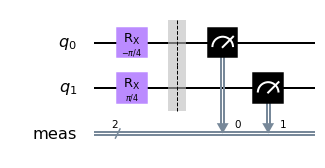

In [13]:
# We add the measurement to our circuit
qc2.measure_all()
qc2.draw(output='mpl')

In [14]:
# Execute our circuit with measurement on the statevector_simulator backend
job = execute(qc2, statevector_simulator)
# From the job object we can retrieve the results 
result = job.result()
# Among other information the result object allows us to retrieve the statevector
psi_with_measurement = result.get_statevector()
print('|psi_with_measurement> =',psi_with_measurement)

|psi_with_measurement> = [ 0.000000e+00+0.j -6.123234e-17+1.j  0.000000e+00+0.j  0.000000e+00+0.j]


### Checking the fidelity
A good measure to check if two pure quantum states are the same is the fidelity
$$F(|\psi_1\rangle, |\psi_2\rangle) = |\langle\psi_1|\psi_2\rangle|^2$$
which is 0 iff $|\psi_1\rangle \bot |\psi_2\rangle$ and 1 iff $|\psi_1\rangle = |\psi_2\rangle$ up to a global phase. 

In [15]:
print('F(|psi>, |psi>) =',state_fidelity(psi,psi))
print('F(|psi>, |psi_with_measurement>) =',state_fidelity(psi,psi_with_measurement))

F(|psi>, |psi>) = 1.0
F(|psi>, |psi_with_measurement>) = 0.12500000000000003


### Visualizing the results from the state vector simulator
The density matrix $\rho = |\psi\rangle\langle\psi|$ can be visualized in various ways as shown in the following.

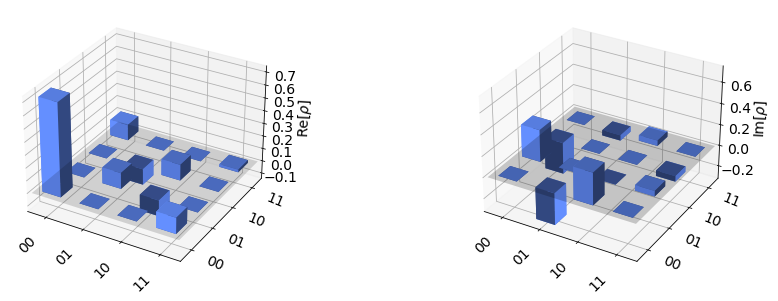

In [16]:
# Plot the real and imaginary parts of the density matrix
plot_state_city(psi)

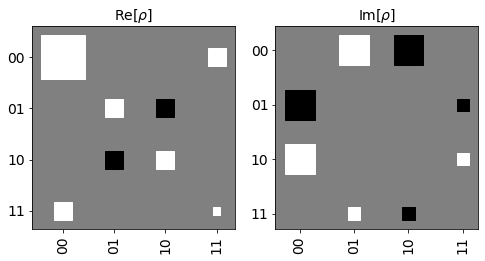

In [17]:
# Plot a 2d projection of the real and imaginary part or the density matrix
plot_state_hinton(psi)

Plot the expansion of the density matrix in the Pauli basis
$$\rho = \sum_{A,B=\{I,X,Y,Z\}}c_{AB}A\otimes B.$$

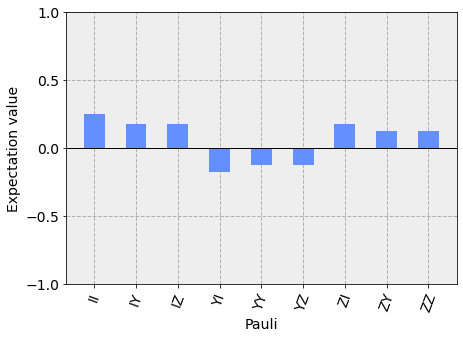

In [18]:
plot_state_paulivec(psi)

## The unitary simulator

The `unitary_simulator` backend allows for the retrieving the unitary matrix corresponding to the quantum circuit one constructed. This is another useful tool, for testing and validating

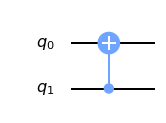

In [19]:
# Construct a quantum circuit with a single CNOT gate as an example
qc3 = QuantumCircuit(2)
qc3.cx(1, 0)
qc3.draw(output='mpl')

Note that we did __not__ add a measurement at the end of the circuit, as this would project the state vector to one of the basis state and yield a nonunitary matrix.

Running the example on the unitary simulator, we can retrieve the matrix representation of our quantum circuit.

In [20]:
# Generate the unitary simulator backend
unitary_simulator = Aer.get_backend('unitary_simulator')
# Execute the circuit on the unitary simulator
job = execute(qc3, unitary_simulator)
# From the job object we can retrieve the results 
result = job.result()
# Among other information the result object allows us to retrieve the unitary
# matrix corresponding to the circuit
unitary = result.get_unitary()
print("Circuit unitary:\n", unitary)

Circuit unitary:
 [[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]]
